In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

model = keras.models.load_model('../models/retinal_disease_classifier.keras')
print("Model loaded successfully!")

X_val = np.load('../data/processed/X_val.npy')
y_val = np.load('../data/processed/y_val.npy')

print(f"Validation data loaded: {X_val.shape}, {y_val.shape}")

/Users/ananthkini/Documents/Retinal Disease Classifier/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Model loaded successfully!
Validation data loaded: (384, 512, 512, 3), (384, 45)


In [2]:
y_pred_probs = model.predict(X_val)

print(f"Predictions shape: {y_pred_probs.shape}")
print(f"Prediction range: {y_pred_probs.min():.3f} to {y_pred_probs.max():.3f}")

print(f"\nFirst image predictions (probabilities for 45 diseases):")
print(y_pred_probs[0])

y_pred_binary = (y_pred_probs >= 0.5).astype(int)

print(f"\nBinary predictions shape: {y_pred_binary.shape}")
print(f"First image binary predictions:")
print(y_pred_binary[0])
print(f"True labels:")
print(y_val[0])

12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step
Predictions shape: (384, 45)
Prediction range: 0.000 to 0.455

First image predictions (probabilities for 45 diseases):
[2.04112738e-01 3.25359181e-02 1.42256856e-01 6.82427138e-02
 4.42929193e-02 1.90279428e-02 5.69903888e-02 2.72844802e-03
 8.52450542e-03 2.24756217e-03 1.17937345e-02 1.56774446e-01
 1.03957308e-02 1.60685473e-03 2.20109266e-03 1.54341850e-02
 2.35994663e-02 1.65673497e-03 3.51334899e-03 1.47679634e-03
 2.97926948e-03 1.91002265e-02 7.87690468e-03 4.54040803e-03
 5.98585419e-03 2.57074647e-03 1.25828781e-03 8.32819787e-04
 2.90506548e-04 6.95295807e-04 8.88493320e-04 1.11413261e-04
 4.76348534e-04 1.45400598e-04 1.20028725e-03 3.29806964e-04
 6.67900953e-04 5.62923786e-04 1.66298298e-04 1.18367803e-04
 2.68820702e-04 2.17795750e-04 2.48522323e-04 1.84745062e-04
 2.82584486e-04]

Binary predictions shape: (384, 45)
First image binary predictions:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 

In [3]:
train_labels = pd.read_csv("../data/raw/Training_Set/RFMiD_Training_Labels.csv")
disease_names = train_labels.columns[2:47].tolist()

from sklearn.metrics import roc_auc_score

disease_aucs = []
for i, disease in enumerate(disease_names):
    try:
        auc = roc_auc_score(y_val[:, i], y_pred_probs[:, i])
        disease_aucs.append(auc)
    except:
        disease_aucs.append(np.nan)  

results_df = pd.DataFrame({
    'Disease': disease_names,
    'AUC': disease_aucs
})
results_df = results_df.sort_values('AUC', ascending=False)

print("Top 10 best performing diseases:")
print(results_df.head(10))
print("\nBottom 10 worst performing diseases:")
print(results_df.tail(10))

Top 10 best performing diseases:
   Disease       AUC
17      ST  0.971279
4      MYA  0.810840
34      TD  0.783290
20      RT  0.756728
24    RPEC  0.730921
0       DR  0.730685
18    AION  0.706806
26      RP  0.704961
14      AH  0.699735
22     CRS  0.697972

Bottom 10 worst performing diseases:
   Disease  AUC
28      CB  NaN
29    ODPM  NaN
30     PRH  NaN
32      HR  NaN
37      CF  NaN
38      VH  NaN
40      VS  NaN
41    BRAO  NaN
42     PLQ  NaN
44      CL  NaN


/Users/ananthkini/Documents/Retinal Disease Classifier/venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/ananthkini/Documents/Retinal Disease Classifier/venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/ananthkini/Documents/Retinal Disease Classifier/venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/ananthkini/Documents/Retinal Disease Classifier/venv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/ananthkini/Documents/Reti

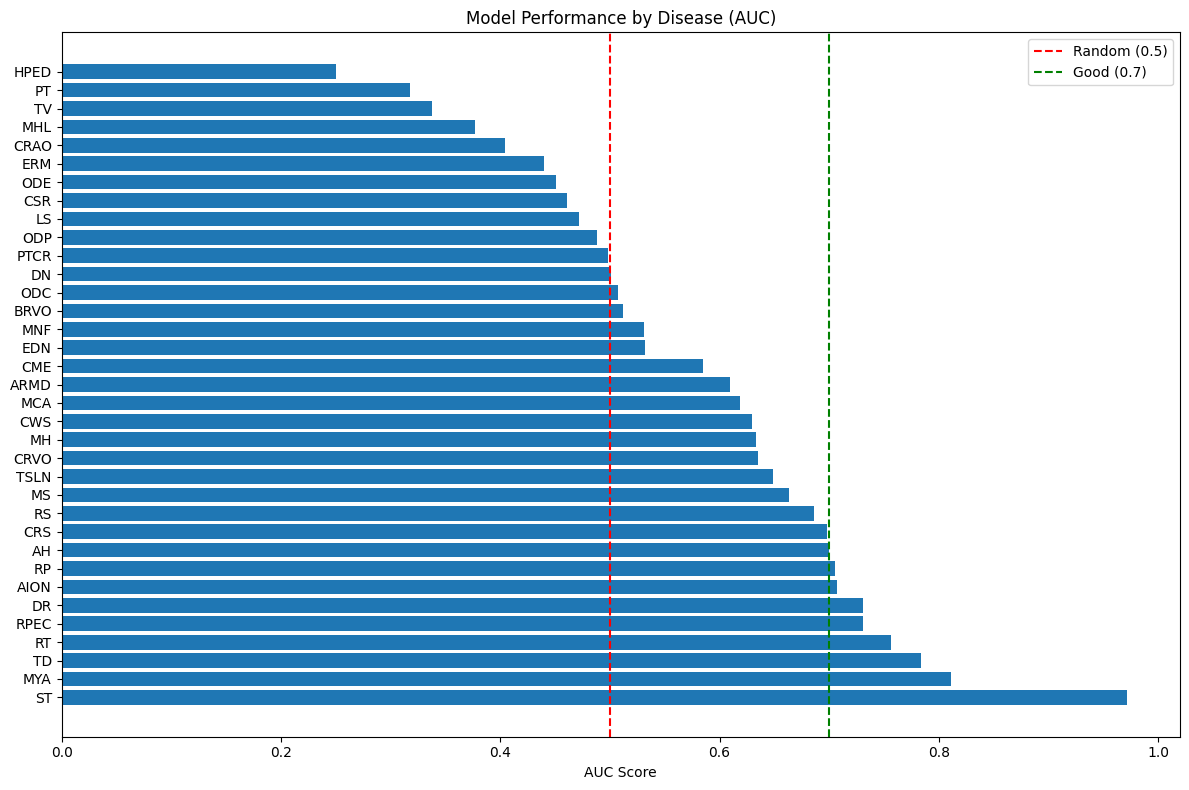


Average AUC across diseases with data: 0.582


In [4]:
# Filter out NaN values
results_clean = results_df.dropna()

# Plot
plt.figure(figsize=(12, 8))
plt.barh(results_clean['Disease'], results_clean['AUC'])
plt.xlabel('AUC Score')
plt.title('Model Performance by Disease (AUC)')
plt.axvline(x=0.5, color='r', linestyle='--', label='Random (0.5)')
plt.axvline(x=0.7, color='g', linestyle='--', label='Good (0.7)')
plt.legend()
plt.tight_layout()
plt.savefig('../results/disease_performance.png')
plt.show()

print(f"\nAverage AUC across diseases with data: {results_clean['AUC'].mean():.3f}")